### **Description**

Recipe showing how to conservatively transform the vertical coordinate system on which a variable is stored using annual-mean outputs from the National Oceanography Centre Near-Present-Day global eORCA1 configuration of NEMO forced using ERA-5 climatologically adjusted atmospheric forcing from 1976-2024.

For more details on this model configuration and the available outputs, users can explore the Near-Present-Day documentation [here](https://noc-msm.github.io/NOC_Near_Present_Day/).

---

In [1]:
# -- Import required packages -- #
import numpy as np
import xarray as xr
from nemo_cookbook import NEMODataTree

xr.set_options(display_style="text")

### **Using Dask**

**Optional: Connect Client to Dask Local Cluster to run analysis in parallel.**

**Note:** Although using Dask is not strictly necessary for this simple example using eORCA1, if we wanted to generalise this recipe to eORCA025 or eORCA12 outputs, using Dask would be essential to avoid unnecessary slow calculations using only a single process.

In [ ]:
# -- Initialise Dask Local Cluster -- #
import os
import dask
from dask.distributed import Client, LocalCluster

# Update temporary directory for Dask workers:
dask.config.set({'temporary_directory': f"{os.getcwd()}/dask_tmp",
                 'local_directory': f"{os.getcwd()}/dask_tmp"
                 })

# Create Local Cluster:
cluster = LocalCluster(n_workers=4, threads_per_worker=3, memory_limit='5GB')
client = Client(cluster)
client

### **Accessing NEMO Model Data**
**Let's begin by loading the grid variables for our eORCA1 NEMO model from the [JASMIN Object Store](https://help.jasmin.ac.uk/docs/short-term-project-storage/using-the-jasmin-object-store/)**. 

**Alternatively, you can replace the ``domain_filepath`` below with a file path to your domain_cfg.nc file and read this with xarray's ``open_dataset()`` function.**

In [2]:
# Define directory path to ancillary files:
domain_filepath = "https://noc-msm-o.s3-ext.jc.rl.ac.uk/npd-eorca1-jra55v1/domain"

# Open eORCA1 NEMO model domain_cfg:
ds_domain = (xr.open_zarr(f"{domain_filepath}/domain_cfg", consolidated=True, chunks={})
             .squeeze()
             .rename({'z': 'nav_lev'})
             )

ds_domain

<xarray.Dataset> Size: 667MB
Dimensions:        (y: 331, x: 360, nav_lev: 75)
Dimensions without coordinates: y, x, nav_lev
Data variables: (12/54)
    e1t            (y, x) float64 953kB dask.array<chunksize=(331, 360), meta=np.ndarray>
    e2v            (y, x) float64 953kB dask.array<chunksize=(331, 360), meta=np.ndarray>
    bottom_level   (y, x) int32 477kB dask.array<chunksize=(331, 360), meta=np.ndarray>
    e2t            (y, x) float64 953kB dask.array<chunksize=(331, 360), meta=np.ndarray>
    e2u            (y, x) float64 953kB dask.array<chunksize=(331, 360), meta=np.ndarray>
    bathy_metry    (y, x) float32 477kB dask.array<chunksize=(331, 360), meta=np.ndarray>
    ...             ...
    nav_lev        (nav_lev) float32 300B dask.array<chunksize=(75,), meta=np.ndarray>
    mask_csundef   (y, x) int32 477kB dask.array<chunksize=(331, 360), meta=np.ndarray>
    nav_lat        (y, x) float32 477kB dask.array<chunksize=(331, 360), meta=np.ndarray>
    nav_lon        (y, x) float32 477kB dask.array<chunksize=(331, 360), meta=np.ndarray>
    time_counter   float64 8B dask.array<chunksize=(), meta=np.ndarray>
    top_level      (y, x) int32 477kB dask.array<chunksize=(331, 360), meta=np.ndarray>
Attributes:
    DOMAIN_number_total:     1
    DOMAIN_number:           0
    DOMAIN_dimensions_ids:   [1, 2]
    DOMAIN_size_global:      [362, 332]
    DOMAIN_size_local:       [362, 332]
    DOMAIN_position_first:   [1, 1]
    DOMAIN_position_last:    [362, 332]
    DOMAIN_halo_size_start:  [0, 0]
    DOMAIN_halo_size_end:    [0, 0]
    DOMAIN_type:             BOX
    history:                 Mon Jun  5 12:41:32 2023: ncks -A mask.nc ORCA1_...
    NCO:                     4.4.7

**Next, we need to import the sea water conservative temperature and absolute salinity stored at T-points in a single dataset.**

In [3]:
# Define directory path to model output files:
output_dir = "https://noc-msm-o.s3-ext.jc.rl.ac.uk/npd-eorca1-jra55v1/T1y"

# Construct NEMO model grid dataset, including seawater conservative temperature (C) and absolute salinity (g/kg):
ds_gridT = xr.merge([xr.open_zarr(f"{output_dir}/{var}", consolidated=True, chunks={'deptht': 75})[var] for var in ['thetao_con', 'e3t']], compat="override")

# Subsetting the time_counter dimension: 
ds_gridT = ds_gridT.sel(time_counter=slice('2000-01', '2010-12'))

### **Creating a NEMODataTree**

**Next, let's create a NEMODataTree to store our domain and T- & V-grid variables for the eORCA1 model.**

In [4]:
# Define dictionary of grid datasets defining eORCA1 parent model domain with no child/grand-child nests:
# Note: domain_cfg z-dimension is expected to be named 'nav_lev'.
datasets = {"parent": {"domain": ds_domain, "gridT": ds_gridT}}

# Initialise a new NEMODataTree whose parent domain is zonally periodic & north-folding on F-points:
nemo = NEMODataTree.from_datasets(datasets=datasets, iperio=True, nftype="F")

nemo

<xarray.DataTree>
Group: /
│   Dimensions:        (time_counter: 11)
│   Coordinates:
│     * time_counter   (time_counter) datetime64[ns] 88B 2000-07-02 ... 2010-07-0...
│       time_centered  (time_counter) datetime64[ns] 88B dask.array<chunksize=(1,), meta=np.ndarray>
│   Attributes:
│       nftype:   F
│       iperio:   True
├── Group: /gridT
│       Dimensions:        (time_counter: 11, k: 75, j: 331, i: 360)
│       Coordinates:
│         * k              (k) int64 600B 1 2 3 4 5 6 7 8 9 ... 68 69 70 71 72 73 74 75
│         * j              (j) int64 3kB 1 2 3 4 5 6 7 8 ... 325 326 327 328 329 330 331
│         * i              (i) int64 3kB 1 2 3 4 5 6 7 8 ... 354 355 356 357 358 359 360
│         * deptht         (k) float32 300B 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
│           time_centered  (time_counter) datetime64[ns] 88B dask.array<chunksize=(1,), meta=np.ndarray>
│           gphit          (j, i) float64 953kB dask.array<chunksize=(331, 360), meta=np.ndarray>
│           glamt          (j, i) float64 953kB dask.array<chunksize=(331, 360), meta=np.ndarray>
│       Data variables:
│           thetao_con     (time_counter, k, j, i) float32 393MB dask.array<chunksize=(1, 75, 331, 360), meta=np.ndarray>
│           e3t            (time_counter, k, j, i) float32 393MB dask.array<chunksize=(1, 75, 331, 360), meta=np.ndarray>
│           e1t            (j, i) float64 953kB dask.array<chunksize=(331, 360), meta=np.ndarray>
│           e2t            (j, i) float64 953kB dask.array<chunksize=(331, 360), meta=np.ndarray>
│           top_level      (j, i) int32 477kB dask.array<chunksize=(331, 360), meta=np.ndarray>
│           bottom_level   (j, i) int32 477kB dask.array<chunksize=(331, 360), meta=np.ndarray>
│           tmask          (k, j, i) bool 9MB False False False ... False False False
│           tmaskutil      (j, i) bool 119kB False False False ... False False False
│       Attributes:
│           nftype:   F
│           iperio:   True
├── Group: /gridU
│       Dimensions:       (j: 331, i: 360, k: 75)
│       Coordinates:
│         * j             (j) int64 3kB 1 2 3 4 5 6 7 8 ... 325 326 327 328 329 330 331
│         * i             (i) float64 3kB 1.5 2.5 3.5 4.5 ... 357.5 358.5 359.5 360.5
│         * k             (k) int64 600B 1 2 3 4 5 6 7 8 9 ... 68 69 70 71 72 73 74 75
│           gphiu         (j, i) float64 953kB dask.array<chunksize=(331, 360), meta=np.ndarray>
│           glamu         (j, i) float64 953kB dask.array<chunksize=(331, 360), meta=np.ndarray>
│       Data variables:
│           e1u           (j, i) float64 953kB dask.array<chunksize=(331, 360), meta=np.ndarray>
│           e2u           (j, i) float64 953kB dask.array<chunksize=(331, 360), meta=np.ndarray>
│           umask         (k, j, i) bool 9MB False False False ... False False False
│           umaskutil     (j, i) bool 119kB False False False ... False False False
│       Attributes:
│           nftype:   F
│           iperio:   True
├── Group: /gridV
│       Dimensions:       (j: 331, i: 360, k: 75)
│       Coordinates:
│         * j             (j) float64 3kB 1.5 2.5 3.5 4.5 ... 328.5 329.5 330.5 331.5
│         * i             (i) int64 3kB 1 2 3 4 5 6 7 8 ... 354 355 356 357 358 359 360
│         * k             (k) int64 600B 1 2 3 4 5 6 7 8 9 ... 68 69 70 71 72 73 74 75
│           gphiv         (j, i) float64 953kB dask.array<chunksize=(331, 360), meta=np.ndarray>
│           glamv         (j, i) float64 953kB dask.array<chunksize=(331, 360), meta=np.ndarray>
│       Data variables:
│           e1v           (j, i) float64 953kB dask.array<chunksize=(331, 360), meta=np.ndarray>
│           e2v           (j, i) float64 953kB dask.array<chunksize=(331, 360), meta=np.ndarray>
│           vmask         (k, j, i) bool 9MB False False False ... False False False
│           vmaskutil     (j, i) bool 119kB False False False ... False False False
│       Attributes:
│           nftype:   F
│           iperio:   True
├── G

### **Exploring our eORCA1 NEMO model vertical coordinate system**

Let's begin by visualising the conservative temperature in the original vertical coordinates of our eORCA1 NPD simulation by plotting a vertical profile at a location in the North Atlantic Ocean:


**By examining the vertical profile & the size of the `k` grid coordinate variable, we can see that our eORCA1 configuration has 75 unevenly-spaced z\*-coordinate levels.**

75


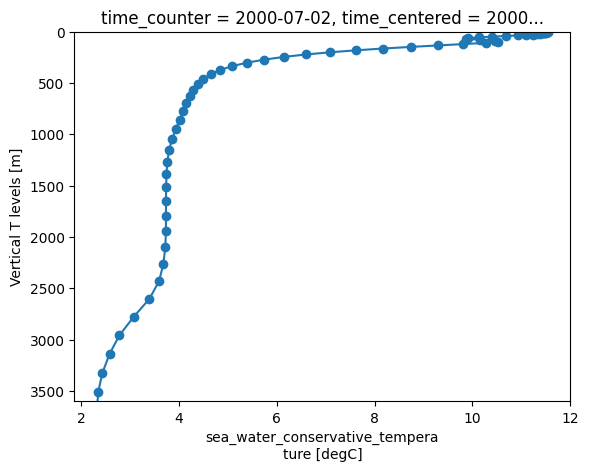

In [5]:
# Plot an example time-mean vertical conservative temperature profile in the subpolar North Atlantic:
nemo['gridT']['thetao_con'].isel(i=260, j=260, time_counter=0).plot(y='deptht', ylim=(3600, 0), marker='o')

# Size of the vertical coordinate dimension:
print(nemo['gridT']['k'].size)

### **Transforming the eORCA1 vertical coordinate system**

**Next, let's apply a conservative vertical coordinate transformation to remap our conservative temperature output to a new regularly-spaced (200 m) vertical grid:**

In [6]:
# Define our target vertical grid coordinate:
e3t_target = xr.DataArray(np.repeat(200.0, 30), dims=['k_new'])

e3t_target

<xarray.DataArray (k_new: 30)> Size: 240B
array([200., 200., 200., 200., 200., 200., 200., 200., 200., 200., 200.,
       200., 200., 200., 200., 200., 200., 200., 200., 200., 200., 200.,
       200., 200., 200., 200., 200., 200., 200., 200.])
Dimensions without coordinates: k_new

In [7]:
# Transform eORCA1 3-dimensional conservative temperature field to new vertical coordinate system:
ds_k_transform = nemo.transform_vertical_grid(grid = 'gridT',
                                              var = 'thetao_con',
                                              e3_new = e3t_target
                                              )

ds_k_transform

<xarray.Dataset> Size: 631MB
Dimensions:        (time_counter: 11, j: 331, i: 360, k_new: 30)
Coordinates:
  * time_counter   (time_counter) datetime64[ns] 88B 2000-07-02 ... 2010-07-0...
  * j              (j) int64 3kB 1 2 3 4 5 6 7 8 ... 325 326 327 328 329 330 331
  * i              (i) int64 3kB 1 2 3 4 5 6 7 8 ... 354 355 356 357 358 359 360
    time_centered  (time_counter) datetime64[ns] 88B dask.array<chunksize=(1,), meta=np.ndarray>
    gphit          (j, i) float64 953kB dask.array<chunksize=(331, 360), meta=np.ndarray>
    glamt          (j, i) float64 953kB dask.array<chunksize=(331, 360), meta=np.ndarray>
    deptht_new     (k_new) float64 240B 200.0 400.0 600.0 ... 5.8e+03 6e+03
Dimensions without coordinates: k_new
Data variables:
    thetao_con     (time_counter, k_new, j, i) float64 315MB dask.array<chunksize=(1, 30, 331, 360), meta=np.ndarray>
    e3t_new        (time_counter, j, i, k_new) float64 315MB dask.array<chunksize=(1, 331, 360, 30), meta=np.ndarray>

**Notice that the output above returns a Dataset containing two DataArrays: the vertically remapped conservative temperature `thetao_con` and the vertical grid cell thicknesses `e3t_out` (accounting for partial grid cell at the sea floor).**

**Since both of these DataArrays contain dask arrays, we haven't actually computed anything yet. To do this, we need to call the ``.compute()`` method:**


In [8]:
ds_k_transform = ds_k_transform.compute()

### **Visualising the vertically transformed conservative temperature field**

**Let's plot the original and vertically transformed conservative temperature profiles together.**

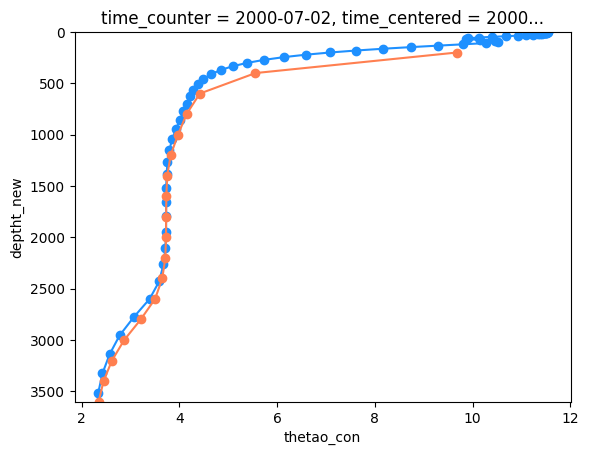

In [9]:
# Plot our original time-mean vertical conservative temperature profile in the subpolar North Atlantic:
nemo['gridT']['thetao_con'].isel(i=260, j=260, time_counter=0).plot(y='deptht', ylim=(3600, 0), marker='o', color='dodgerblue')

# Plot our vertically transformed time-mean vertical conservative temperature profile in the subpolar North Atlantic:
ds_k_transform['thetao_con'].isel(i=260, j=260, time_counter=0).plot(y='deptht_new', ylim=(3600, 0), marker='o', color='coral')

**We can also verify that the product of the vertical grid cell thickness (m) and conservative temperature (C) is conserved following the transformation.**

**Note that we need to transform all variables to a consistent `dtype` (in this case float64) before making the comparison.**

In [10]:
# Calculate the sum of the product of the transformed conservative temperature and cell thickness at our example location:
print((ds_k_transform['thetao_con'].isel(time_counter=0, i=260, j=260).astype(np.float64) * ds_k_transform['e3t_new'].isel(time_counter=0, i=260, j=260).astype(np.float64)).sum().compute())

# Calculate the sum of the product of the original conservative temperature and cell thickness at our example location:
print((nemo['gridT']['thetao_con'].isel(time_counter=0, i=260, j=260).astype(np.float64) * nemo['gridT']['e3t'].isel(time_counter=0, i=260, j=260).astype(np.float64)).sum().compute())

<xarray.DataArray ()> Size: 8B
array(14272.51116587)
Coordinates:
    time_counter   datetime64[ns] 8B 2000-07-02
    time_centered  datetime64[ns] 8B 2000-07-02
    gphit          float64 8B 51.34
    glamt          float64 8B -26.44
    j              int64 8B 261
    i              int64 8B 261
<xarray.DataArray ()> Size: 8B
array(14272.51116587)
Coordinates:
    time_counter   datetime64[ns] 8B 2000-07-02
    time_centered  datetime64[ns] 8B 2000-07-02
    gphit          float64 8B 51.34
    glamt          float64 8B -26.44
    j              int64 8B 261
    i              int64 8B 261
